In [36]:
import numpy as np
from numba import jit
from matplotlib import colormaps
import os


import matplotlib.image as mpimg
from matplotlib.colors import rgb_to_hsv, LogNorm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rc('figure', dpi=250)

In [25]:
def load_hsv_image(filename):
    image = mpimg.imread(filename).copy()
    image = rgb_to_hsv(image[:,:,:3])
    image[:,:,2] = 1.0 - image[:,:,2]/255
    return image

def load_rgb_image(filename):
    image = mpimg.imread(filename).copy()
    image = image[:,:,:3]
    return image

In [26]:
def combimap(cmap, n_levels=256):
    primary_cmap = colormaps.get(cmap)
    grey_cmap = colormaps.get('Greys')
    colors = np.vstack((
        primary_cmap(np.linspace(0.0, 1.0, n_levels)),
        grey_cmap(np.linspace(0.0, 1.0, n_levels//2))
    ))
    print(colors.shape)
    cmap_combi = ListedColormap(colors)
    return cmap_combi

In [27]:
def find_unique_colors(image):
    im = image.copy()
    shape = image.shape
    image = im.reshape((shape[0]*shape[1], 3))
    unique_colors = np.unique(image, axis=0)
    return unique_colors

@jit
def hsv_to_cartesian(hsv):
    return np.array([
        hsv[1] * np.cos(2*np.pi*hsv[0]),
        hsv[1] * np.sin(2*np.pi*hsv[0]),
        hsv[2] * hsv[1],
    ])


class Colormap():
    def __init__(self, cmap, n_levels=128):
        if isinstance(cmap, str):
            self.cmap = colormaps.get(cmap)
        else:
            self.cmap = cmap
        self.values = np.linspace(0.0, 1.0, n_levels, endpoint=True)
        self.colors = self.cmap(self.values)[:,:3]

        # self.colors = rgb_to_hsv(self.cmap(self.values)[:,:3])

@jit(nopython=True)
def distance(a, b) -> float:
    return np.linalg.norm(a-b)
    # a_c, b_c = hsv_to_cartesian(a), hsv_to_cartesian(b)
    # return np.sqrt((a_c[0]-b_c[0])**2 + (a_c[1]-b_c[1])**2 + (a_c[2]-b_c[2])**2)

@jit(nopython=True)
def best_value(colors, values, distances, color):
    for i in range(colors.shape[0]):
        distances[i] = distance(color, colors[i])
    best_index = np.argmin(distances)
    return values[best_index]


@jit(nopython=True)
def lookup_values(colors, values, distances, image_v, im):
    for i in range(image_v.shape[0]):
        image_v[i] = best_value(colors, values, distances, im[i])

def create_value_image(cmap, image):
    # Save original shape
    shape = image.shape
    # Flatten
    im = image.reshape((shape[0]*shape[1], 3))
    # Create target arrays
    image_v = np.ndarray((shape[0]*shape[1]), dtype=float)
    distances = np.ndarray(cmap.colors.shape[0])
    
    # Find values for the value image
    lookup_values(cmap.colors, cmap.values, distances, image_v, im)

    # Reshape value image back to the original shape
    image_v = image_v.reshape((shape[0], shape[1], 1))
    return image_v


In [30]:
filename = "davis-rainbow.png"

ref_cmap = combimap('jet')
# ref_cmap = colormaps.get('hot')

cmap = Colormap(ref_cmap, n_levels=256)

image = load_rgb_image(filename)
# print(image)

size = image.shape[0]*image.shape[1]
print(size)

image_v = create_value_image(cmap, image)
# print(image_v)

(384, 4)
246012


(384, 4)


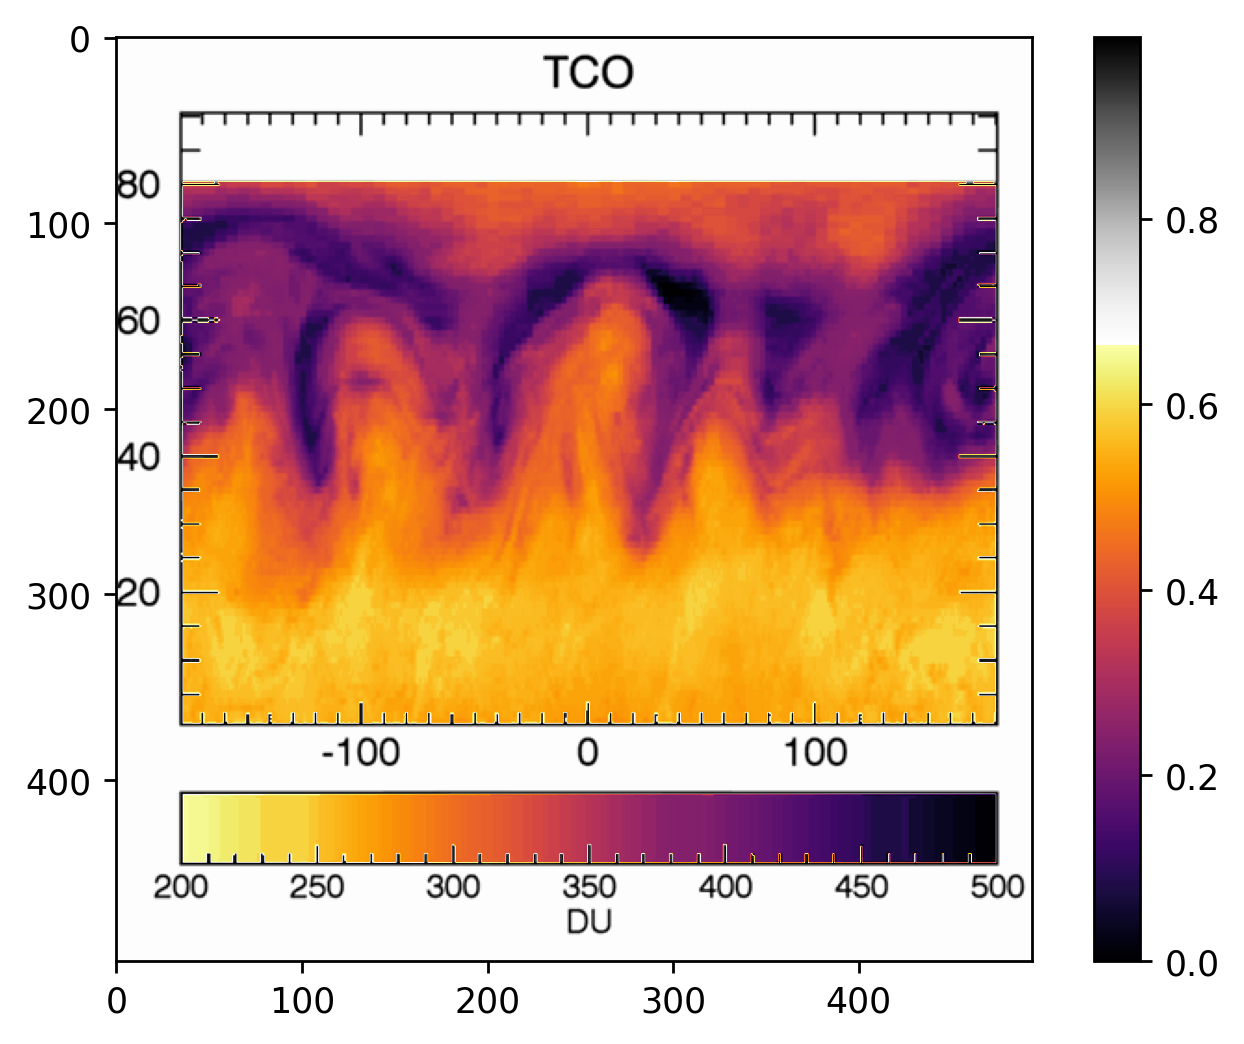

In [44]:
plot_cmap_name = 'inferno'
plot_cmap = combimap(plot_cmap_name)
im = plt.imshow(image_v, cmap=plot_cmap) #, norm=LogNorm())
plt.colorbar(im)
output_filename = f'{os.path.splitext(filename)[0]}_{plot_cmap_name}_recovered.png'
plt.savefig(output_filename, bbox_inches='tight')